In [468]:
#Import Libraries
import numpy as np
import pandas as pd
import os 
import itertools 
import uproot
import time
import awkward as ak
from IPython.display import display, HTML
import hist
#import vector
import pickle
import matplotlib.pyplot as plt

import xgboost
print(xgboost.__version__)
import sklearn
print (sklearn.__version__)

1.7.3
0.23.2


## Load datasets and concatenate

In [674]:
#Set to read all columns
pd.set_option('display.max_columns', None)

#Import and concatenate the training sets
df_bkg = pd.read_csv('bkg_train')
df_sig = pd.read_csv('sig_train_barrel')
df = pd.concat([df_bkg,df_sig], ignore_index=True)


## Begin Training

In [675]:
#Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [676]:
#Check columns of df
df.columns

Index(['Event #', 'Mult', 'MDT', 'RPC', 'TGC', 'ntrks', 'Vtx_eta', 'Vtx_phi',
       'Vtx_Sum_pT', 'jet_pt_1', 'jet_eta_1', 'jet_phi_1', 'jet_logRatio_1',
       'jet_jvt_1', 'delta_jet_1', 'jet_pt_2', 'jet_eta_2', 'jet_phi_2',
       'jet_logRatio_2', 'jet_jvt_2', 'delta_jet_2', 'jet_pt_3', 'jet_eta_3',
       'jet_phi_3', 'jet_logRatio_3', 'jet_jvt_3', 'delta_jet_3', 'track_pt_1',
       'delta_track_1', 'track_pt_2', 'delta_track_2', 'track_pt_3',
       'delta_track_3', 'Label'],
      dtype='object')

In [677]:
#Delcare Target
#WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = df["Label"]

In [678]:
# For simplicity only keep some most important features. Can add more later down below
data=pd.DataFrame(df, columns=['Mult','ntrks','Vtx_eta','Vtx_phi','Vtx_Sum_pT','jet_pt_1','jet_eta_1','jet_phi_1','delta_jet_1','track_pt_1','delta_track_1'])

print ("Df shape of dataset to be used :",data.shape)
display(data.head())
display(target.head())


Df shape of dataset to be used : (23238, 11)


,Mult,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,delta_jet_1,track_pt_1,delta_track_1
0,1.0,6,1.291129,2.547647,0.000000,14.120969,0.805406,2.308828,0.292961,0.843345,0.174086
1,1.0,5,-0.470793,-1.863787,9829.156418,956.929625,-0.423354,-1.910104,0.004396,4.504998,0.000386
2,1.0,5,-1.326776,2.561106,0.000000,15.583394,-1.094044,2.926301,0.187531,1.058478,0.113148
3,1.0,11,-1.491744,-0.558659,5853.233708,1194.077875,-1.433871,-0.473610,0.010583,4.486927,0.000335
4,1.0,5,-0.234525,0.995545,9264.656169,212.110547,-0.150425,0.954939,0.008722,142.210916,0.001539


0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Label, dtype: float64

In [679]:
more_features = False
if (more_features):
    data=pd.DataFrame(df, columns=['Event #', 'Mult', 'MDT', 'RPC', 'TGC', 'ntrks', 'Vtx_eta', 'Vtx_phi',
       'Vtx_Sum_pT', 'Label', 'jet_pt_1', 'jet_eta_1', 'jet_phi_1',
       'jet_logRatio_1', 'jet_jvt_1', 'delta_jet_1', 'jet_pt_2', 'jet_eta_2',
       'jet_phi_2', 'jet_logRatio_2', 'jet_jvt_2', 'delta_jet_2', 'track_pt_1',
       'delta_track_1', 'track_pt_2', 'delta_track_2', 'track_pt_3','delta_track_3'])
print ("Df shape of dataset to be used :",data.shape)

Df shape of dataset to be used : (23238, 11)


### PreProcess the data

In [680]:
#np.random.seed(31415)

from sklearn.model_selection import train_test_split
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, = train_test_split(data, target, train_size=train_size)

#Reset index for dataseries, not needed for ndarray (X_train, X_test)
#Basically just re-adding the original element indexing from pandas
y_train, y_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True)

print ("X_train shape:",X_train.shape)
print ("y_train shape:",y_train.shape)


print ("X_test shape:",X_test.shape)
print ("y_test shape:",y_test.shape)


X_train shape: (17428, 11)
y_train shape: (17428,)
X_test shape: (5810, 11)
y_test shape: (5810,)


### Train the BDT

In [681]:
np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0

xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss')



starting_time = time.time()

xgb.fit(X_train, y_train.values) 
        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

## prediction on test data by trained BDT classifier
y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
#prediction on train data by BDT classifier
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb),"\n")

/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training time: 0.3650960922241211
auc test: 0.9205313337456195
auc train: 0.9980977175856305 



In [617]:
#Overfit....try to add some rough cuts and see if it performs better. ALso consider adding more jets and tracks and see what happens
#Plot hist of BDT output of signal to bkg
#Correlation of the features

In [668]:
#define a function to compare train and test
# Plot score for signal and background, comparing training and testing
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), 
                       bins=30,xlabel="", ylabel="Arbitrary units", title="", 
                       #weights_train=np.array([]), weights_test=np.array([]),
                       density=True):
    
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='S (train)') # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='B (train)')

    
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=density)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=density)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')

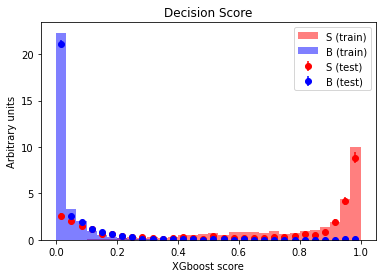

In [669]:
compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, 
                   xlabel="XGboost score", title="Decision Score") 
                   #weights_train=weights_train.values, weights_test=weights_test.values)

plt.savefig("Score_BDT_XGBoost_Hist.pdf")

## Hyperparameter Optimization

In [670]:
#This takes a while. Feel free to come back here after finishing
do_HP_optimization = True

In [672]:
#RandomSearchCV for advanced HPO 
import scipy.stats as stats
if do_HP_optimization:
    from sklearn.model_selection import RandomizedSearchCV

    # specify parameters, range, and distributions to sample from
    param_dist_XGB = {'max_depth': stats.randint(3, 12), # default 6
                      'n_estimators': stats.randint(300, 800), #default 100
                      'learning_rate': stats.uniform(0.1, 0.5)} #def 0.3 

    # default CV is 5 fold, reduce to 2 for speed concern
    gsearch = RandomizedSearchCV(estimator = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss'), 
                        param_distributions = param_dist_XGB, 
                        scoring='roc_auc',n_iter=10,cv=2)
    gsearch.fit(X_train,y_train)

    print ("Best parameters : ",gsearch.best_params_)
    print ("Best score (on train dataset CV) : ",gsearch.best_score_)


    y_pred_gs = gsearch.predict_proba(X_test)[:,1]
    print("... corresponding score on test dataset : ",roc_auc_score(y_true=y_test, y_score=y_pred_gs))
    dfsearch=pd.DataFrame.from_dict(gsearch.cv_results_)
    display(dfsearch)

/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`

Best parameters :  {'learning_rate': 0.470811843873447, 'max_depth': 4, 'n_estimators': 418}
Best score (on train dataset CV) :  0.9239994366909619
... corresponding score on test dataset :  0.9295001341652283


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.829373,0.028056,0.064800,0.015897,0.422909,6,313,"{'learning_rate': 0.42290930295437734, 'max_de...",0.919379,0.927633,0.923506,0.004127,2
1,1.554580,0.202000,0.074350,0.011924,0.585352,5,690,"{'learning_rate': 0.5853519930243356, 'max_dep...",0.916913,0.924170,0.920541,0.003628,9
2,0.925073,0.014225,0.045282,0.001815,0.554533,8,314,"{'learning_rate': 0.554532921359051, 'max_dept...",0.918891,0.926924,0.922907,0.004016,6
3,1.284601,0.194456,0.046451,0.008908,0.572983,3,692,"{'learning_rate': 0.5729827777333318, 'max_dep...",0.920804,0.925904,0.923354,0.002550,3
4,0.893331,0.153751,0.038754,0.000915,0.470812,4,418,"{'learning_rate': 0.470811843873447, 'max_dept...",0.921815,0.926184,0.923999,0.002185,1
5,1.552689,0.193747,0.063568,0.015624,0.404303,4,616,"{'learning_rate': 0.40430322715768163, 'max_de...",0.918899,0.926244,0.922571,0.003673,7
6,1.345680,0.051210,0.057776,0.001532,0.433429,9,410,"{'learning_rate': 0.4334288747439906, 'max_dep...",0.920685,0.925507,0.923096,0.002411,5
7,1.056859,0.207866,0.051321,0.001937,0.584544,10,350,"{'learning_rate': 0.5845439889186795, 'max_dep...",0.918854,0.926180,0.922517,0.003663,8
8,1.551829,0.102389,0.101418,0.020459,0.298821,6,629,"{'learning_rate': 0.2988212925946424, 'max_dep...",0.920334,0.926061,0.923198,0.002863,4
9,1.343553,0.077163,0.071676,0.000059,0.552594,6,704,"{'learning_rate': 0.5525940072045796, 'max_dep...",0.916796,0.923872,0.920334,0.003538,10


/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


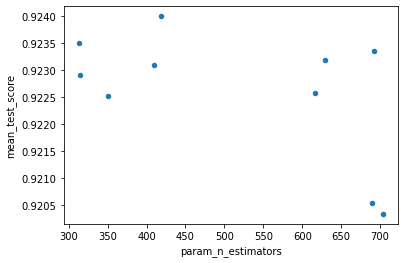

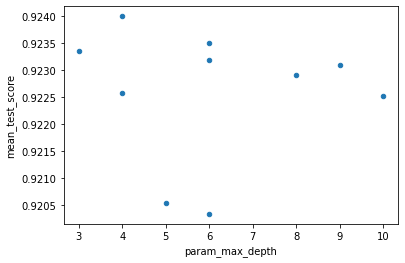

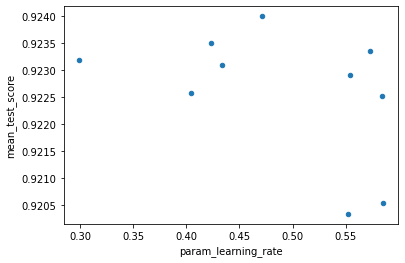

In [673]:
if do_HP_optimization: 
    dfsearch.plot.scatter("param_n_estimators","mean_test_score")
    dfsearch.plot.scatter("param_max_depth","mean_test_score")
    dfsearch.plot.scatter("param_learning_rate","mean_test_score")

## Learning Curve - How learning changes with training size

In [623]:

from sklearn.metrics import roc_curve

Do_Learning_Curve = True

if Do_Learning_Curve : 
    train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
    ntrains=[]
    test_aucs=[]
    train_aucs=[]
    times=[]
    fpr=[]
    tpr=[]

    for train_size in train_sizes:
        ntrain=int(len(X_train)*train_size)
        print("training with ",ntrain," events")
        ntrains+=[ntrain]
        starting_time = time.time()

        # train using the first ntrain event of the training dataset
        xgb.fit(X_train[:ntrain], y_train[:ntrain])
        training_time = time.time( ) - starting_time
        times+=[training_time]

        # score on test dataset (always the same)
        y_pred_xgb=xgb.predict_proba(X_test)[:,1]
        auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
        test_aucs+=[auc_test_xgb]

        # score on the train dataset 
        y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
        auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb)
        train_aucs+=[auc_train_xgb]
        dflearning=pd.DataFrame({"Ntraining":ntrains,
                             "test_auc":test_aucs,
                             "train_auc":train_aucs,
                             "time":times})
        
        temp_fpr, temp_tpr,_ = roc_curve(y_true=y_train[:ntrain], y_score=y_train_xgb)
        fpr+=[temp_fpr]
        tpr+=[temp_tpr]
        
    display(dflearning)

training with  174  events
training with  871  events
training with  1742  events
training with  3485  events
training with  8714  events
training with  13071  events
training with  17428  events


,Ntraining,test_auc,train_auc,time
0,174,0.911415,1.000000,0.071698
1,871,0.914185,1.000000,0.081916
2,1742,0.922032,1.000000,0.167713
3,3485,0.926792,1.000000,0.132477
4,8714,0.925274,0.999721,0.234720
5,13071,0.928058,0.999247,0.291092
6,17428,0.931385,0.998527,0.452159


In [624]:
###### NEED TO SEE WHY train_auc is 1.0 here ############

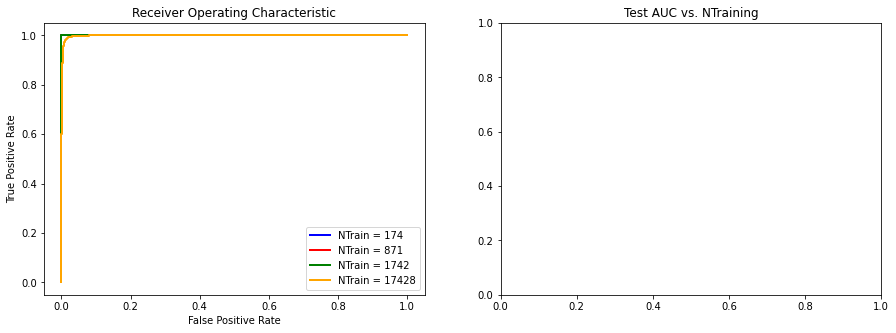

In [625]:
if Do_Learning_Curve:
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    lw = 2
    #axes[0].plot(fpr_xgb, tpr_xgb, color='blue',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
    axes[0].plot(fpr[0], tpr[0], color='blue',lw=lw, label='NTrain = %i'%(ntrains[0]))
    axes[0].plot(fpr[1], tpr[1], color='red',lw=lw, label='NTrain = %i'%(ntrains[1]))
    axes[0].plot(fpr[2], tpr[2], color='green',lw=lw, label='NTrain = %i'%(ntrains[2]))
    axes[0].plot(fpr[6], tpr[6], color='orange',lw=lw, label='NTrain = %i'%(ntrains[6]))
    
    axes[0].legend()
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic')
    
    axes[1].set_title("Test AUC vs. NTraining")
    #dflearning.plot.scatter("Ntraining","test_auc",ax=axes[1])
    # focus on the last point
    #dflearning[4:].plot.scatter("Ntraining","test_auc")

## Feature Importance

Text(0.5, 1.0, 'Feature importances XGBoost Hist')

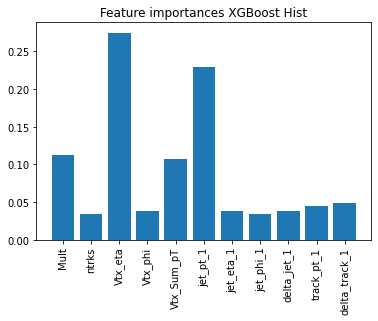

In [626]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")

## Permutation Importance

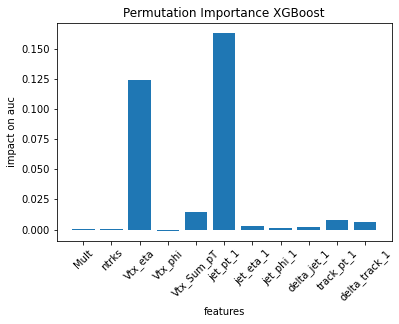

In [627]:
Do_Permutation = True
if Do_Permutation:
    from sklearn.inspection import permutation_importance
    r = permutation_importance(xgb, X_test, y_test,
                           scoring='roc_auc',n_repeats=1,n_jobs=-1,
                            random_state=0)
    plt.bar(data.columns,r.importances.mean(axis=1).T,)

    plt.xlabel('features')
    plt.ylabel('impact on auc')
    plt.title('Permutation Importance XGBoost')
    plt.xticks(rotation=45)  # Rotate labels by 45 degrees
    plt.show()

## Overtraining the BDT

/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training time: 20.263671875
auc test: 0.9237713053325924
auc train: 1.0 



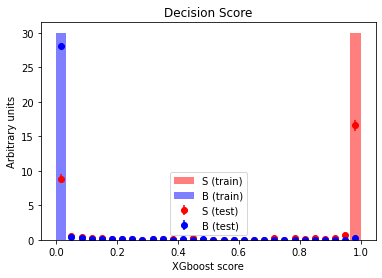

In [631]:
n_trees = 20000

#defining new XGBClassifier with more trees
xgb = XGBClassifier(tree_method="hist",n_estimators=n_trees, use_label_encoder=False,eval_metric='logloss')
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0

# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
#xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 


starting_time = time.time()

xgb.fit(X_train, y_train.values) # note that XGB 1.3.X requires positive weight
        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

## prediction on test data by trained BDT classifier
y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
#prediction on train data by BDT classifier
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb),"\n")

compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, 
                   xlabel="XGboost score", title="Decision Score")
